In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import os
import gc
import time
import importlib
import sklearn.preprocessing as pp
import sklearn.model_selection as ms
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from recommender import item_based, dummy as dummy_recommender, preprocessing as rpp, model_selection as rms,\
    tools as rtools, experiment_tools

import tag_genome_builder as tg_builder
from tag_genome_builder import model_selection as ms_tg_builder

from lib import tools
import config
import config_tag_recommender
def reload():
    importlib.reload(item_based)
    importlib.reload(dummy_recommender)
    importlib.reload(config)
    importlib.reload(tg_builder)
    importlib.reload(rpp)
    importlib.reload(rms)
    importlib.reload(tools)
    importlib.reload(config_tag_recommender)
    importlib.reload(ms_tg_builder)
    importlib.reload(rtools)
    importlib.reload(experiment_tools)
    
    

# input params

In [2]:
reload()
str_aggregated_path = config_tag_recommender.str_aggregated_path
str_genome_scores = config_tag_recommender.str_genome_scores
str_tags = config_tag_recommender.str_tags
str_tag_ids = config_tag_recommender.str_tag_ids
str_rating_path = config_tag_recommender.str_rating_path
str_data_folder = config_tag_recommender.str_data_folder
minimum_no_of_frames = config_tag_recommender.minimum_no_of_frames
number_of_tag_per_movie = config_tag_recommender.number_of_tag_per_movie
n_jobs = 5

In [3]:
print('str_aggregated_path =', str_aggregated_path)
print('str_genome_scores =', str_genome_scores)
print('str_tags =', str_tags)
print('str_tag_ids =', str_tag_ids)
print('str_rating_path =', str_rating_path)
print('str_data_folder =', str_data_folder)
print('str_aggregated_path =', str_aggregated_path)
print('minimum_no_of_frames =', minimum_no_of_frames)
print('number_of_tag_per_movie =', number_of_tag_per_movie)

str_aggregated_path = ..\..\data\MA14KD_AGGREGATED.csv
str_genome_scores = ..\..\data\ml-25m\genome-scores.csv
str_tags = ..\..\data\ml-25m\tags.csv
str_tag_ids = ..\..\data\ml-25m\genome-tags.csv
str_rating_path = ..\..\data\ml-25m\ratings.csv
str_data_folder = ..\..\data
str_aggregated_path = ..\..\data\MA14KD_AGGREGATED.csv
minimum_no_of_frames = 10
number_of_tag_per_movie = 10


# Read inputs

In [4]:
df_tag_ids = pd.read_csv(str_tag_ids, index_col=config.tagId_col)

In [5]:
# df_tag_ids.head()

In [6]:
df_genome = pd.read_csv(str_genome_scores)

In [7]:
df_ratings = pd.read_csv(str_rating_path, nrows=None)

In [8]:
usecols = ['movieId', 'no_key_frames']
for i in range(1,11):
    usecols += [f'f{i}_median', f'f{i}_quartile1', f'f{i}_quartile3', f'f{i}_std'] 
print(len(usecols))
usecols = usecols


df_agg = pd.read_csv(str_aggregated_path, nrows=None, usecols=usecols, index_col=config.movieId_col).sort_index()
df_agg = df_agg[df_agg['no_key_frames'] >= minimum_no_of_frames]
df_agg.dropna(axis=1, thresh=len(df_agg) - 1000, inplace=True)

42


In [9]:
print('The size of datasets before filtering to the same:')
print('VF:', df_agg.shape,'Tag genome:', df_genome[config.movieId_col].nunique())
df_agg, df_genome = tg_builder.Base().filter_tag_and_vf_to_same(df_agg=df_agg, df_genome_scores=df_genome)
print('The size of datasets after filtering to the same:')
print('VF:', df_agg.shape,'Tag genome:', df_genome[config.movieId_col].nunique())

The size of datasets before filtering to the same:
VF: (13923, 39) Tag genome: 13816
The size of datasets after filtering to the same:
VF: (6469, 39) Tag genome: 6469


In [10]:
vf_item_features =rpp.ItemFeature()
vf_item_features.from_dataframe(df_agg)

In [11]:
item_features = rpp.get_item_feature_from_tag_genome(df_genome, number_of_tag_per_movie)

In [12]:
df_ratings_filtered = df_ratings[df_ratings[config.movieId_col].isin(item_features.item_ids)]
user_activities = df_ratings_filtered[config.userId_col].value_counts()
df_ratings_filtered = df_ratings_filtered[df_ratings_filtered[config.userId_col].\
                                          isin(user_activities[user_activities > 1].index)]

# Compute tag genome based on visual features

In [13]:
normalizer = pp.QuantileTransformer(output_distribution='normal')
# normalizer = pp.StandardScaler()


In [14]:
%%time
reload()
df_predicted_tag_genome = ms_tg_builder.cross_val_predict(df_visual_features=df_agg,
                                                          df_genome_scores=df_genome,
                                                          normalizer_vf=normalizer,
                                                          n_splits=10, 
                                                          n_jobs=n_jobs)


Wall time: 21 s


In [15]:
item_features_vf_tg = rpp.get_item_feature_from_tag_genome(df_predicted_tag_genome, number_of_tag_per_movie)

# Train test split
## rating dataset and tag item features

In [16]:
reload()
df_rating_train, df_rating_test = \
    rms.train_test_split(df_ratings_filtered, item_features=None, strategy='sklearn', test_size=.25)

In [17]:
vf_normalizer = tg_builder.VisualFeatureNormalizer()
normalizer = pp.StandardScaler()
df_agg_train = df_agg.loc[df_rating_train[config.movieId_col].unique()]
df_agg_train_normalized = vf_normalizer.fit_transform(df_agg_train, normalizer)
df_agg_test = df_agg.loc[df_rating_test[config.movieId_col].unique()]
df_agg_test_normalized = vf_normalizer.transform(df_agg_test)

item_features_vf_train = rpp.ItemFeature()
item_features_vf_train.from_dataframe(df_agg_train_normalized)
item_features_vf_test = rpp.ItemFeature()
item_features_vf_test.from_dataframe(df_agg_test_normalized)


## tag genome computed using visual features

In [18]:
reload()
item_features_vf_tg_train, item_features_vf_tg_test = \
(item_features_vf_tg.get_item_feature_by_list_of_items(df_rating_train[config.movieId_col].unique()),
item_features_vf_tg.get_item_feature_by_list_of_items(df_rating_test[config.movieId_col].unique()))

# Train the content based recommender and predict on test on VF tag genome

In [ ]:
reload()
df_rating_test = \
experiment_tools.get_predictions_for_different_number_of_tags(df_predicted_tag_genome,
                                                              np.arange(1,11),
                                                              df_rating_train,
                                                              df_rating_test,
                                                              n_jobs=n_jobs)


# looking at the performance

1

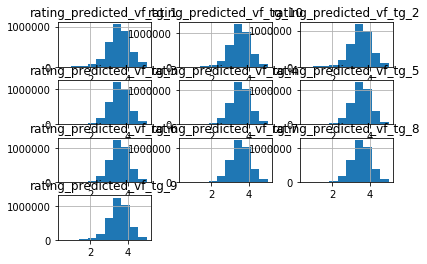

In [ ]:
df_rating_test.filter(regex='rating_predicted').hist()
1

In [ ]:
prediction_column_suffixes = []
for c in df_rating_test.filter(regex='rating_predicted').columns:
    c = c.replace('rating_predicted', '')
    c = c[1:] if len(c) > 0 else c
    prediction_column_suffixes.append(c)
prediction_column_suffixes

['vf_tg_1',
 'vf_tg_2',
 'vf_tg_3',
 'vf_tg_4',
 'vf_tg_5',
 'vf_tg_6',
 'vf_tg_7',
 'vf_tg_8',
 'vf_tg_9',
 'vf_tg_10']

In [ ]:
reload()
df_performance_report = pd.concat([tools.performance_report(df_rating_test, 
                                                           prediction_column_suffix=alg) 
                                  for alg in prediction_column_suffixes]).sort_values('RMSE')
df_performance_report

,Average Score,MAE,RMSE,NRMSE,R2,Std of residuals,Avg of residuals,Coverage
vf_tg_10,3.530341,0.751557,0.972043,0.275340,0.162954,0.972041,0.001570,0.998680
vf_tg_9,3.530374,0.751856,0.972531,0.275475,0.162065,0.972529,0.001843,0.998412
vf_tg_8,3.530335,0.752124,0.972958,0.275599,0.161321,0.972957,0.001708,0.998167
vf_tg_7,3.530124,0.752774,0.974066,0.275930,0.159433,0.974065,0.001502,0.997473
vf_tg_6,3.530230,0.753773,0.975665,0.276374,0.156760,0.975663,0.001805,0.996399
vf_tg_5,3.530083,0.754661,0.977113,0.276796,0.154180,0.977111,0.002111,0.995534
vf_tg_4,3.529848,0.756040,0.979380,0.277457,0.150106,0.979373,0.003909,0.993541
vf_tg_3,3.529184,0.758541,0.983708,0.278735,0.142532,0.983704,0.002571,0.990285
vf_tg_2,3.526992,0.764304,0.993345,0.281641,0.125360,0.993341,0.002519,0.980147
vf_tg_1,3.514706,0.777638,1.017240,0.289424,0.082406,1.017239,-0.001253,0.923158


## performance table for copying into Latex

In [ ]:
print(df_performance_report.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Average Score &       MAE &      RMSE &     NRMSE &        R2 &  Std of residuals &  Avg of residuals &  Coverage \\
\midrule
vf\_tg\_10 &       3.530341 &  0.751557 &  0.972043 &  0.275340 &  0.162954 &          0.972041 &          0.001570 &  0.998680 \\
vf\_tg\_9  &       3.530374 &  0.751856 &  0.972531 &  0.275475 &  0.162065 &          0.972529 &          0.001843 &  0.998412 \\
vf\_tg\_8  &       3.530335 &  0.752124 &  0.972958 &  0.275599 &  0.161321 &          0.972957 &          0.001708 &  0.998167 \\
vf\_tg\_7  &       3.530124 &  0.752774 &  0.974066 &  0.275930 &  0.159433 &          0.974065 &          0.001502 &  0.997473 \\
vf\_tg\_6  &       3.530230 &  0.753773 &  0.975665 &  0.276374 &  0.156760 &          0.975663 &          0.001805 &  0.996399 \\
vf\_tg\_5  &       3.530083 &  0.754661 &  0.977113 &  0.276796 &  0.154180 &          0.977111 &          0.002111 &  0.995534 \\
vf\_tg\_4  &       3.529848 &  0.756040 &  0.9

## Some plots

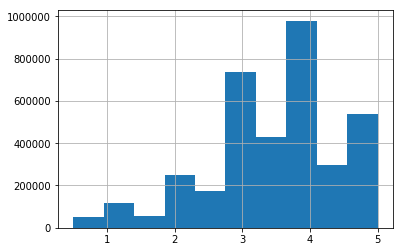

In [ ]:
df_rating_test[config.rating_col].hist()

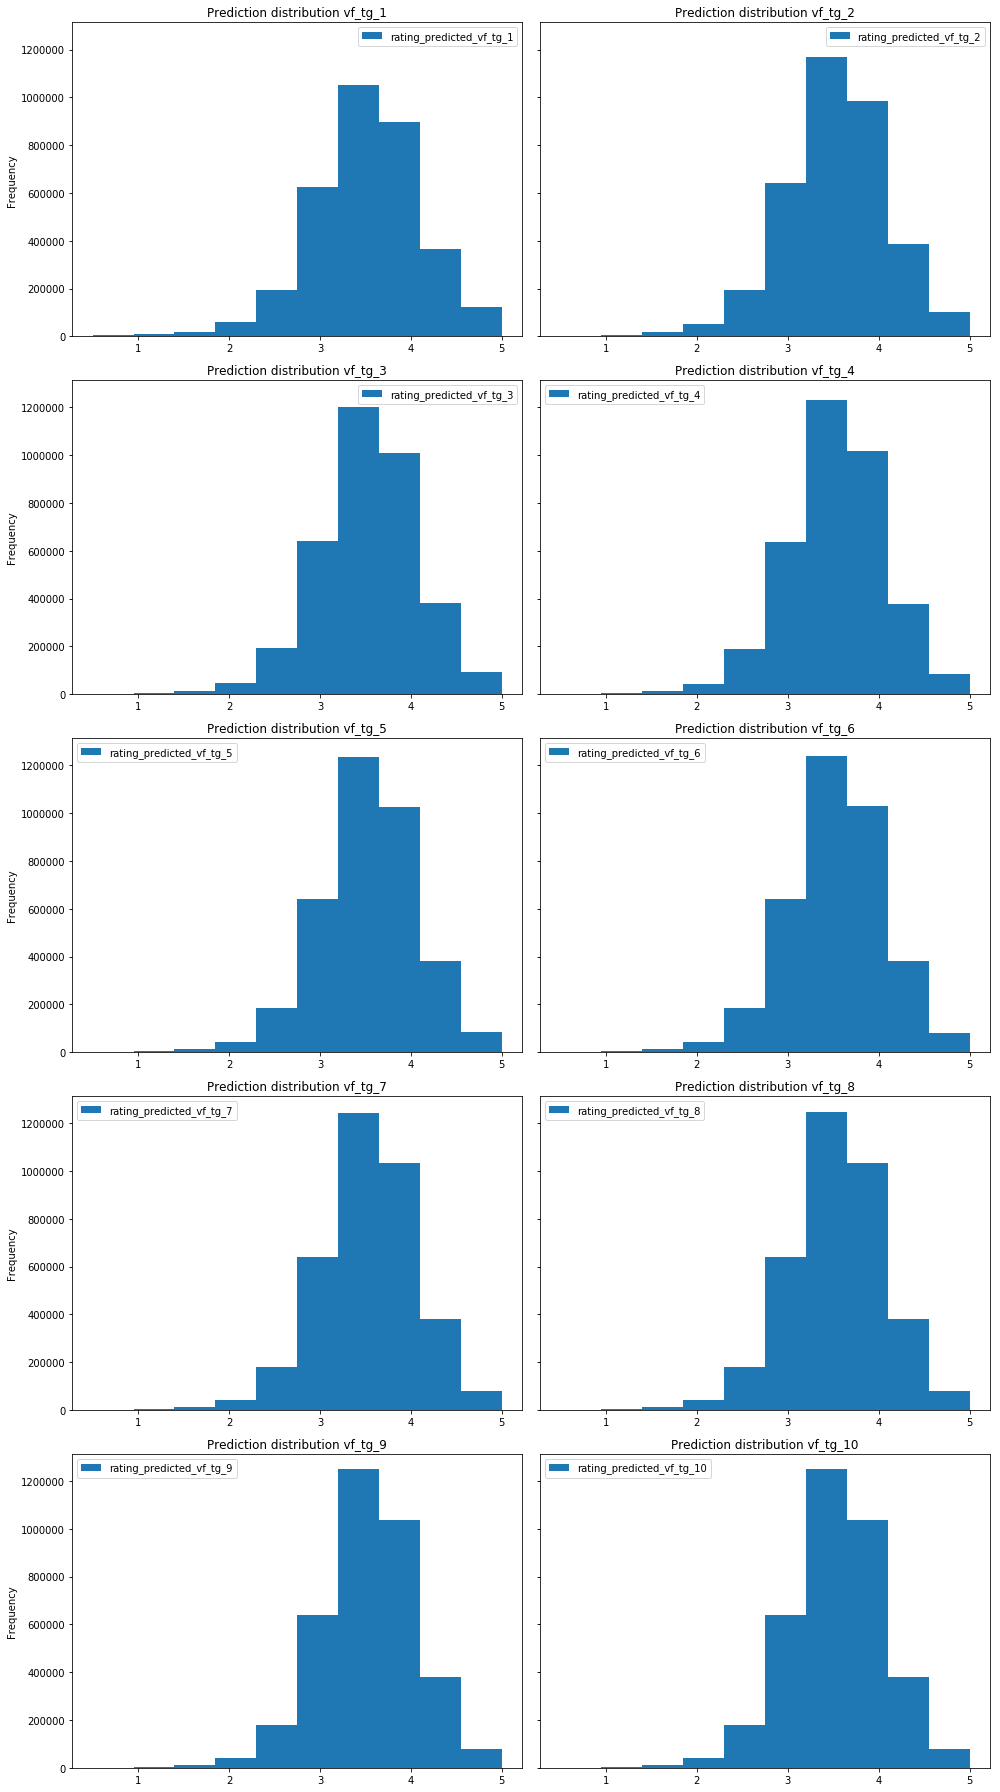

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_prediction_histogram,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

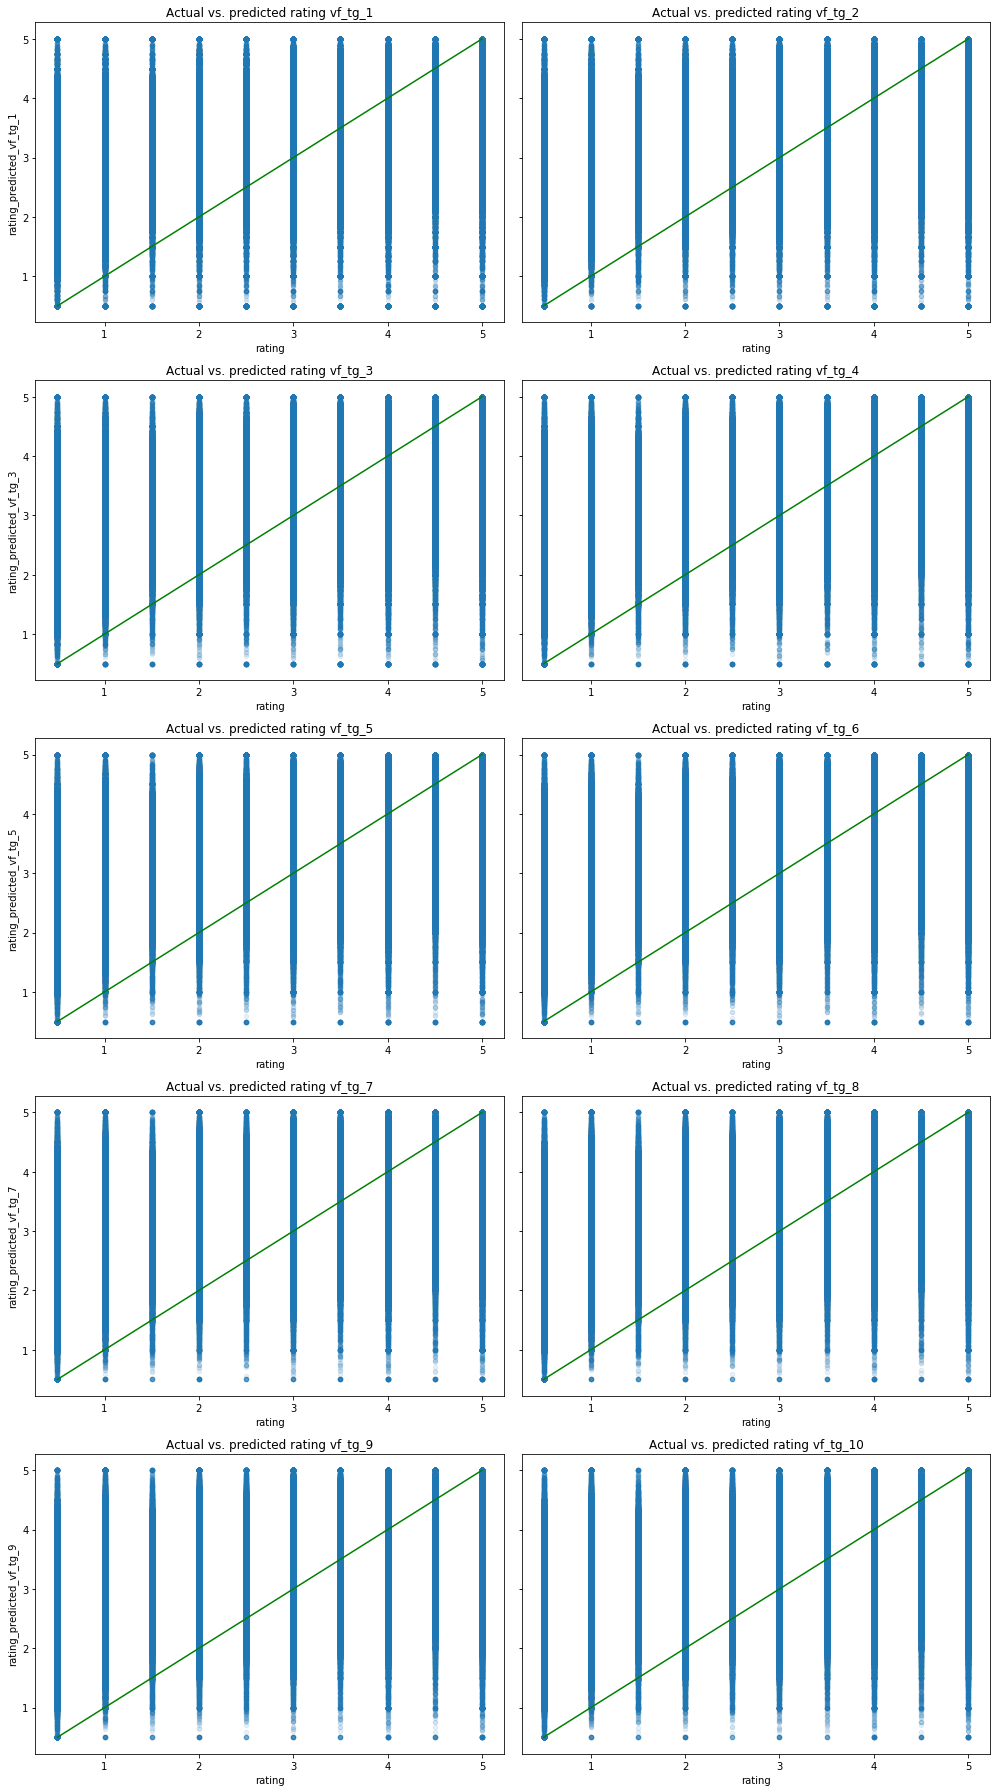

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_prediction,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes,
                            alpha=.1)

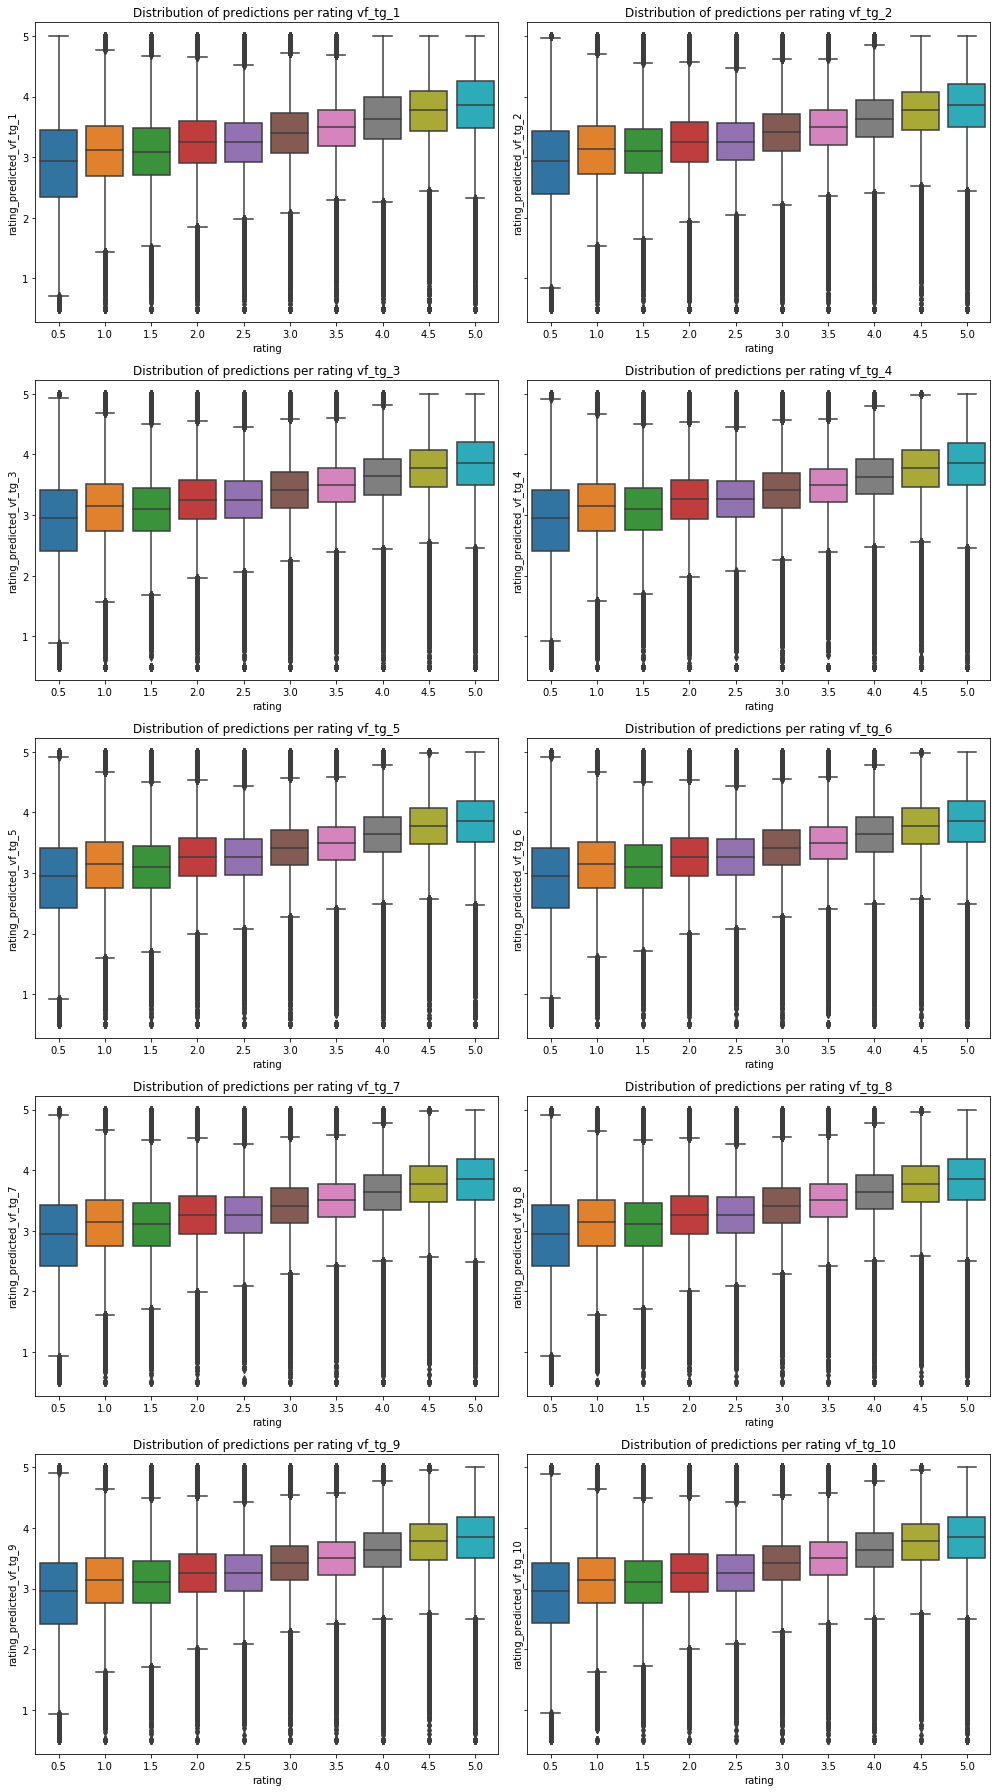

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

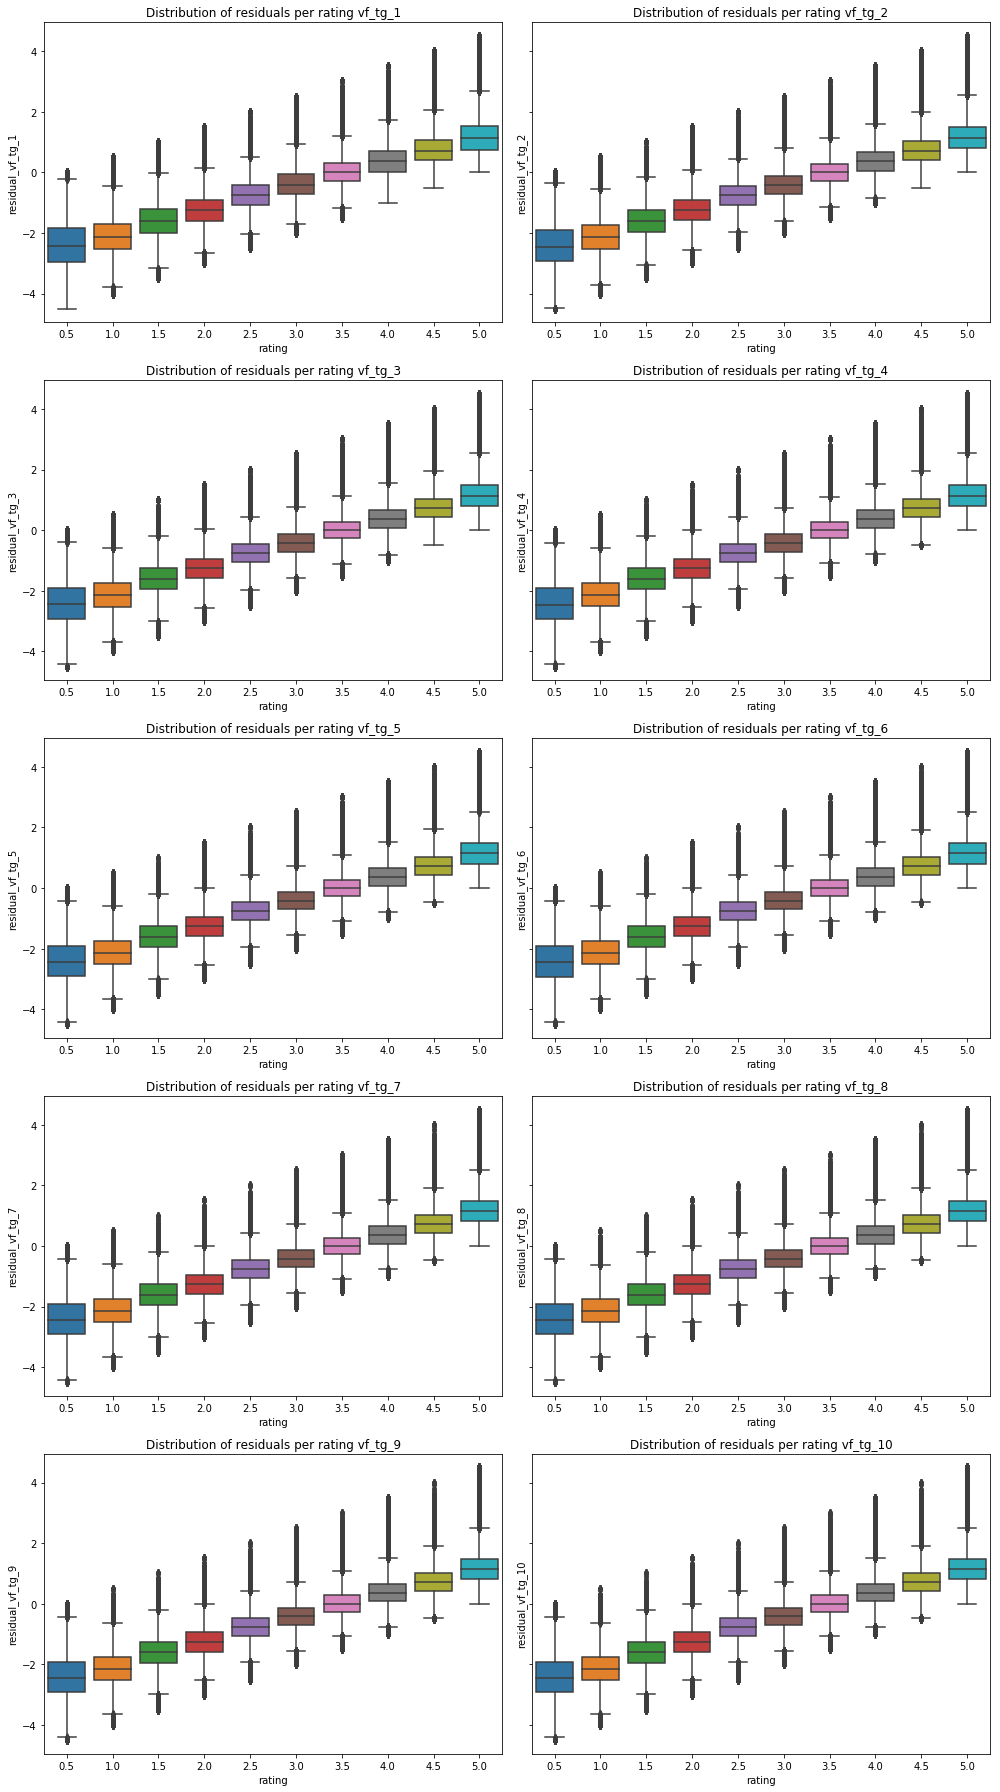

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_residual_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

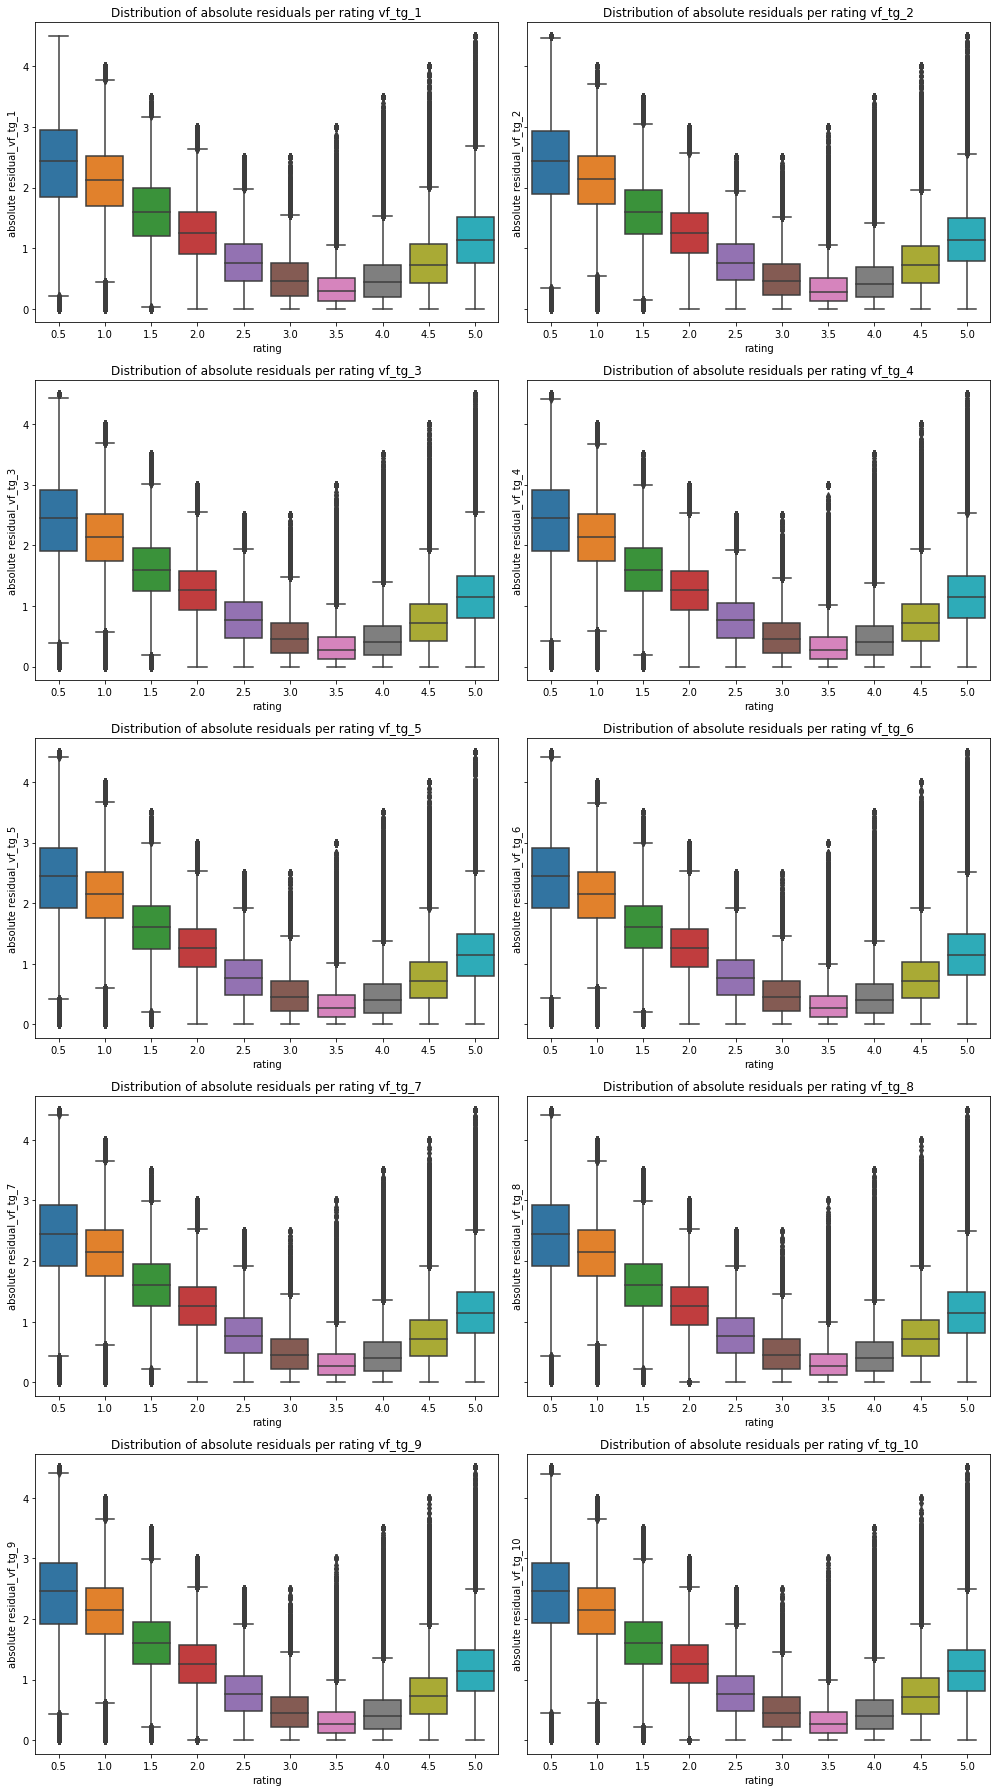

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_absolute_residual_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

In [ ]:
# reload()
# _ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_violinplot,
#                             df_rating_pred=df_rating_test,
#                             prediction_column_suffixes=prediction_column_suffixes)

# Save the current notebook into results folder and push to the repository

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
from notebook import notebookapp
import urllib
import json
import os
import ipykernel

currentTime = lambda : time.strftime('%Y-%m-%d-%H%M')
def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

notebook_dir, notebook_name = os.path.split(notebook_path())
output = os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}.ipynb')
os.system(f'jupyter nbconvert --to ipynb {notebook_path()} --output {output}')
os.system(f'git add {output}')
os.system(f'git commit -m "result computed on {currentTime()}"')
os.system('git push')

In [ ]:
df_rating_test.to_csv(os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}_df_rating_test.csv'))